# Klasifikasi Brain Plane

- Arsitektur : Vgg-16
- Tujuan     : Melihat perbandingan hasil akurasi model berdasarkan jumlah epoch (20 dan 30)
- Jumlah Kelas : 3 (Trans-Cerebellum, Trans-Thalamic, Trans-ventricular)


**Oleh**

#### Muhammad Rezky Hamesi Akhyar
#### 09011281924038

## Import Library dan Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report


from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
#from keras.optimizers import Adam, RMSprop

warnings.filterwarnings(action="ignore")
%matplotlib inline

## Variabel

In [ ]:
base_dir = 'drive/MyDrive/Dataset/PCD/Brain_Plane'
labels = sorted(os.listdir('drive/MyDrive/Dataset/PCD/Brain_Plane/train'))
labels.pop(0)
target_size = target_size=(150,150)
NUM_CLASSES = len(labels)
batch_size = 32

In [ ]:
labels

['Trans-cerebellum', 'Trans-thalamic', 'Trans-ventricular']

In [ ]:
os.listdir(base_dir)

['train', 'test']

## Pengolahan Data

### Grouping Data

In [ ]:
def grouping_data(dir_image, total_image):
    data_img = {}
    data_dir = {}
    for label in labels:
        data_dir[label] = os.path.join(dir_image, label)
        data_img[label] = os.listdir(data_dir[label])

    img_data = []
    label_data = []

    for label in labels:
        for i in range(total_image):
            img_data.append(os.path.join(data_dir[label], data_img[label][i]))
            label_data.append(label)
            
    # convert data ke dataframe
    Fseries = pd.Series(img_data, name="image")
    Lseries = pd.Series(label_data, name="labels")
    object_data = pd.concat([Fseries,Lseries], axis=1)
    
    return pd.DataFrame(object_data)

In [ ]:
# mengambil data train
train_dir = os.path.join(base_dir,"train")
data_train_df = grouping_data(train_dir, 477)

# mengambil data test
test_dir = os.path.join(base_dir,"test")
data_test_df = grouping_data(test_dir, 80)

In [ ]:
print(data_train_df["image"][0])
print(data_test_df["image"][0])

drive/MyDrive/Dataset/PCD/Brain_Plane/train/Trans-cerebellum/Patient00815_Plane3_3_of_3.png
drive/MyDrive/Dataset/PCD/Brain_Plane/test/Trans-cerebellum/Patient01506_Plane3_2_of_2.png


In [ ]:
data_train_df

,image,labels
0,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-cerebellum
1,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-cerebellum
2,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-cerebellum
3,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-cerebellum
4,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-cerebellum
...,...,...
1426,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-ventricular
1427,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-ventricular
1428,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-ventricular
1429,drive/MyDrive/Dataset/PCD/Brain_Plane/train/Tr...,Trans-ventricular


In [ ]:
data_test_df

,image,labels
0,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-cerebellum
1,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-cerebellum
2,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-cerebellum
3,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-cerebellum
4,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-cerebellum
...,...,...
235,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-ventricular
236,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-ventricular
237,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-ventricular
238,drive/MyDrive/Dataset/PCD/Brain_Plane/test/Tra...,Trans-ventricular


### Split dan Load Data
Split to Train_Set and Val_Set , Load Data With keras API

In [ ]:
#Membagi sampel data
train_set, val_set = train_test_split(data_train_df, test_size=0.2, random_state=42)


In [ ]:
#shape of splitted data
print(train_set.shape)
print(val_set.shape)

(1144, 2)
(287, 2)


In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="image",y_col="labels",
                                      target_size=target_size,
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=batch_size,
                                      shuffle=True 
                                     )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="image", y_col="labels",
                                    target_size=target_size,
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=batch_size,
                                    shuffle=False
                                   )
test = image_gen.flow_from_dataframe(dataframe= data_test_df,x_col="image", y_col="labels",
                                     target_size=target_size,
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=batch_size,
                                     shuffle= False
                                    )

Found 1144 validated image filenames belonging to 3 classes.
Found 287 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Trans-cerebellum', 'Trans-thalamic', 'Trans-ventricular']


### Preview Data

In [ ]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

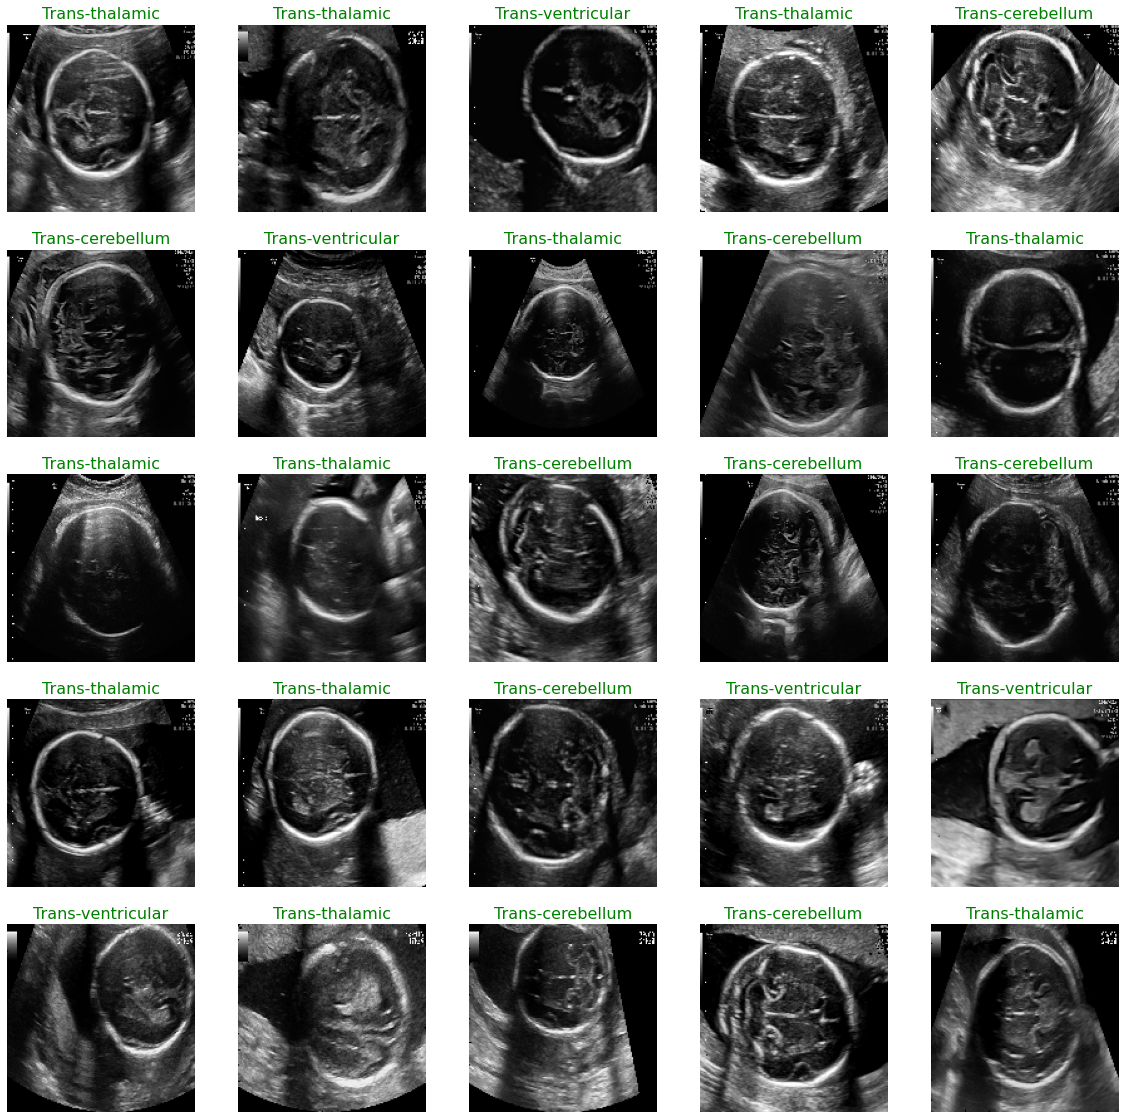

In [ ]:
show_images(train)

## Pengaturan Model

### Deklarasi Model

In [ ]:
# configuration base model
base_model = VGG16(
    include_top=False, 
    input_shape=target_size + (3,)
)
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# custom model
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 3)                 24579     
                                                                 
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
steps_per_epoch = train_set.shape[0] // batch_size
validation_step = val_set.shape[0] // batch_size
epoch1 = 30
epoch2 = 20

## EPOCH 30

### Train Model

In [ ]:
callbacks1 = [ModelCheckpoint('drive/MyDrive/Dataset/PCD/Model/Model_vgg16_30.h5', verbose=1, save_best_only=True)]

In [ ]:
#fitting model

start = time.time()
History1 = model.fit(train, 
                     validation_data= val, 
                     validation_steps=validation_step, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epoch1, 
                     verbose=1, 
                     callbacks=callbacks1)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 1.1978 - accuracy: 0.4712
Epoch 1: val_loss improved from inf to 0.80724, saving model to drive/MyDrive/Dataset/PCD/Model/Model_vgg16_30.h5
35/35 [==============================] - 24s 555ms/step - loss: 1.1978 - accuracy: 0.4712 - val_loss: 0.8072 - val_accuracy: 0.6445
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.8584 - accuracy: 0.6313
Epoch 2: val_loss improved from 0.80724 to 0.71485, saving model to drive/MyDrive/Dataset/PCD/Model/Model_vgg16_30.h5
35/35 [==============================] - 18s 521ms/step - loss: 0.8584 - accuracy: 0.6313 - val_loss: 0.7149 - val_accuracy: 0.7070
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.7595 - accuracy: 0.6754
Epoch 3: val_loss improved from 0.71485 to 0.68089, saving model to drive/MyDrive/Dataset/PCD/Model/Model_vgg16_30.h5
35/35 [==============================] - 19s 539ms/step - loss: 0.7595 - accuracy: 0.6754 - val_loss: 0.

### Evaluasi untuk Epoch 30

In [ ]:
model1 = load_model('drive/MyDrive/Dataset/PCD/Model/Model_vgg16_30.h5', )

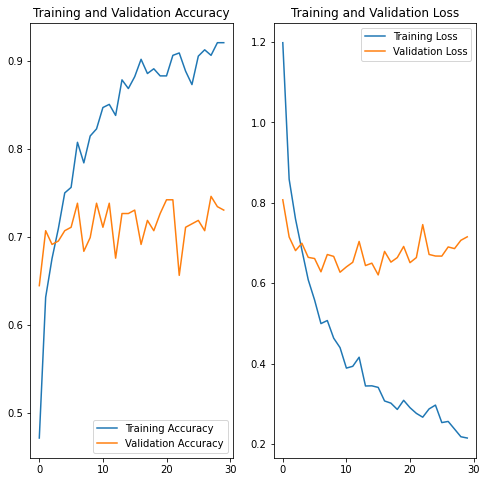

In [ ]:
# tampilkan hasil akurasi kedalam plot
accuracy1 = History1.history['accuracy']
val_accuracy1 = History1.history['val_accuracy']

loss1 = History1.history['loss']
val_loss1 = History1.history['val_loss']

epochs_range = range(epoch1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy1, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model1.evaluate(test, verbose=1)

8/8 [==============================] - 5s 565ms/step - loss: 0.7069 - accuracy: 0.6792


[0.7068535685539246, 0.6791666746139526]

In [ ]:
pred1 = model1.predict(test)
pred1 = np.argmax(pred1, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds1 = [labels[k] for k in pred1]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

y_test = data_test_df.labels # set y_test to the expected output
print(classification_report(y_test, preds1))
print("Accuracy of the Model:",accuracy_score(y_test, preds1)*100,"%")

                   precision    recall  f1-score   support

 Trans-cerebellum       0.79      0.78      0.78        80
   Trans-thalamic       0.56      0.60      0.58        80
Trans-ventricular       0.69      0.66      0.68        80

         accuracy                           0.68       240
        macro avg       0.68      0.68      0.68       240
     weighted avg       0.68      0.68      0.68       240

Accuracy of the Model: 67.91666666666667 %


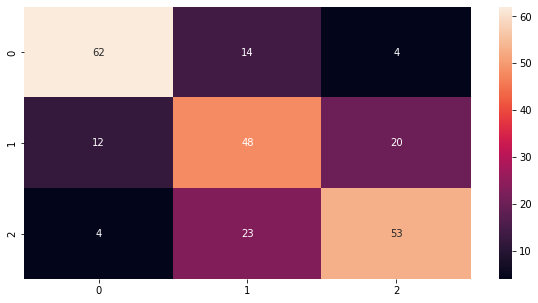

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm1 = confusion_matrix(y_test, preds1)
sns.heatmap(cm1, annot=True, fmt = 'g')

## EPOCH 20

### Train Model

In [ ]:
callbacks2 = [ModelCheckpoint('drive/MyDrive/Dataset/PCD/Model/Model_vgg16_20.h5', verbose=1, save_best_only=True)]

In [ ]:
#fitting model

start = time.time()
History2 = model.fit(train, 
                     validation_data= val, 
                     validation_steps=validation_step, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epoch2, 
                     verbose=1, 
                     callbacks=callbacks2)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9137
Epoch 1: val_loss improved from inf to 0.68185, saving model to drive/MyDrive/Dataset/PCD/Model/Model_vgg16_20.h5
35/35 [==============================] - 18s 513ms/step - loss: 0.2278 - accuracy: 0.9137 - val_loss: 0.6819 - val_accuracy: 0.7344
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9272
Epoch 2: val_loss did not improve from 0.68185
35/35 [==============================] - 18s 502ms/step - loss: 0.2156 - accuracy: 0.9272 - val_loss: 0.6821 - val_accuracy: 0.7500
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9137
Epoch 3: val_loss did not improve from 0.68185
35/35 [==============================] - 17s 497ms/step - loss: 0.2343 - accuracy: 0.9137 - val_loss: 0.6896 - val_accuracy: 0.7422
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9335
Epoch 4: val_loss di

### Evaluasi untuk Epoch 20

In [ ]:
model2 = load_model('drive/MyDrive/Dataset/PCD/Model/Model_vgg16_20.h5', )

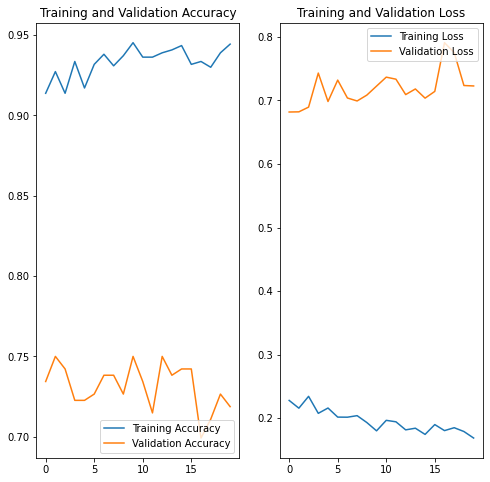

In [ ]:
# tampilkan hasil akurasi kedalam plot
accuracy2 = History2.history['accuracy']
val_accuracy2 = History2.history['val_accuracy']

loss2 = History2.history['loss']
val_loss2 = History2.history['val_loss']

epochs_range = range(epoch2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy2, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model2.evaluate(test, verbose=1)

8/8 [==============================] - 3s 354ms/step - loss: 0.7436 - accuracy: 0.6917


[0.7435991168022156, 0.6916666626930237]

In [ ]:
pred2 = model2.predict(test)
pred2 = np.argmax(pred2, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds2 = [labels[k] for k in pred2]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

y_test = data_test_df.labels # set y_test to the expected output
print(classification_report(y_test, preds2))
print("Accuracy of the Model:",accuracy_score(y_test, preds2)*100,"%")

                   precision    recall  f1-score   support

 Trans-cerebellum       0.79      0.80      0.80        80
   Trans-thalamic       0.61      0.55      0.58        80
Trans-ventricular       0.67      0.72      0.69        80

         accuracy                           0.69       240
        macro avg       0.69      0.69      0.69       240
     weighted avg       0.69      0.69      0.69       240

Accuracy of the Model: 69.16666666666667 %


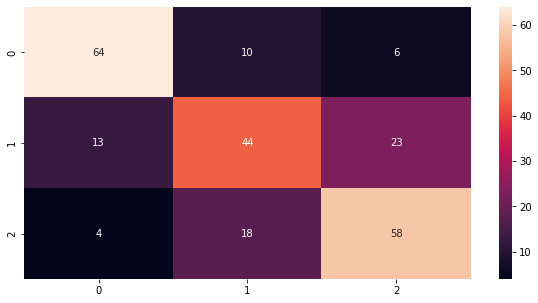

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm2 = confusion_matrix(y_test, preds2)
sns.heatmap(cm2, annot=True, fmt = 'g')

## Perbandingan

In [ ]:
hasil1 = accuracy_score(y_test, preds1) * 100
hasil2 = accuracy_score(y_test, preds2) * 100
dic = {'Epoch 30' : [str(round((hasil1))) + '%'], 'Epoch 20' : [str(round((hasil2))) + '%']}

df_hasil = pd.DataFrame(data = dic)
df_hasil

,Epoch 30,Epoch 20
0,68%,69%
